# PHY 604: Homework #7 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

<div style="background-color: powderblue; color: black; padding: 10px;">

1. (this is Newman 10.11) _Dimer covering problem_.  Dimers are
  two-atom polymers.  Imagine dimers landing on the surface of a
  solid, falling into the gaps between other dimers.  They will cover
  the surface looking something like this:
  ![dimers](dimers.png)
    
  <p>No dimers are allowed to overlap.  Here we will use simulated annealing to 
  find out how many dimers can fit in a $L\times L$ square (we know the answer
  is simply $L^2/2$, but there are more complicated versions of this problem
  where we might not know the answer ahead of time).

  <p>Write a program to solve this problem using simulated annealing on a
  $50\times 50$ lattice.  The energy of the system is _minus_ the
  number of dimers, so that is minimized when the dimers are a
  maximum.  The moves for the Markov chain are:

   <ul>
     <li>Choose two adjacent sites on the lattice at random</li>
     <li>If those two sites are currently occupied by a single dimer,
      remove the dimer from the lattice</li>
     <li>If, instead, they are currently both empty, add a dimer</li>
     <li>Otherwise, do nothing</li>
   </ul>

  <p>Use an expontential cooling schedule and try out different time
  constants.  A reasonable first value to try is $\tau = 10000$~steps.
  For faster cooling schedules, you should see that the solutions
  found are poorer---a smaller fraction of the lattice is filled with
  dimers and there are larger holes between them.  For slower
  schedules, the calculation can find quite good, but usually not perfect,
  coverings of the lattice.



</div>

We'll create a class that stores a single dimer's location.  Then we'll manage a list of Dimer objects that live on the lattice.

In [2]:
class Dimer(object):
    """ a single dimer """
    def __init__(self, p1, p2):
        """p1 and p2 are the spatial locations in the grid of the dimer (x1,
        y1), and (x2, y2)"""

        self.p1 = p1
        self.p2 = p2

The Lattice class manages our lattice with dimers.

In [3]:
class Lattice(object):
    """ a lattice that the dimers occupy """
    def __init__(self, N):
        self.N = N

        self.dimers = []

    def dimer_occupied(self, p1, p2):
        """ check if points p1 and p2 are occupied by a single dimer return that object """

        for d in self.dimers:
            if d.p1 == p1 and d.p2 == p2 or d.p1 == p2 and d.p2 == p1:
                return d

        return None

    def is_free(self, p):
        """ check if point p is free """

        free = True
        for d in self.dimers:
            if d.p1 == p or d.p2 == p:
                free = False

        return free

    def energy(self):
        """ the enery is just the negative of the number of dimers """
        return -len(self.dimers)

    def is_on_lattice(self, p):
        """ given a point p, make sure it is on the lattice """
        return p[0] >= 0 and p[0] < self.N and p[1] >= 0 and p[1] < self.N

    def do_work(self):
        """we will choose two adjacent sites on the lattice, if they are
        occupied by a single dimer, we remove it, if they are both empty, we
        add a dimer, otherwise, we do nothing"""

        x1 = np.random.randint(0, self.N)
        y1 = np.random.randint(0, self.N)

        # the second point should be adjacent, so we randomly pick a direction
        valid = False
        while not valid:
            d = np.random.randint(1, 5)
            if d == 1:
                x2 = x1 + 1
                y2 = y1
            elif d == 2:
                x2 = x1 - 1
                y2 = y1
            elif d == 3:
                x2 = x1
                y2 = y1 + 1
            elif d == 4:
                x2 = x1
                y2 = y1 - 1

            valid = self.is_on_lattice((x2, y2))

        # store, in case we undo
        p1 = (x1, y1)
        p2 = (x2, y2)

        self.d_removed = None
        self.d_added = None

        d = self.dimer_occupied(p1, p2)
        if d is not None:
            self.d_removed = d
            self.dimers.remove(d)

        elif self.is_free(p1) and self.is_free(p2):
            d = Dimer(p1, p2)
            self.dimers.append(d)
            self.d_added = d

    def undo_work(self):
        """undo our last move"""

        # if we added a dimer, then remove it
        if self.d_added is not None:
            self.dimers.remove(self.d_added)

        # if we removed a dimer, then add it back
        if self.d_removed is not None:
            self.dimers.append(self.d_removed)

    def plot(self):

        for d in self.dimers:
            plt.scatter([d.p1[0], d.p2[0]], [d.p1[1], d.p2[1]], marker="x", s=250/self.N)
            plt.plot([d.p1[0], d.p2[0]], [d.p1[1], d.p2[1]])

Our simulated annealing will be handled by the `optimize()` function.  This will do the exponential cooling.  We take a single argument, which is the size of the lattice, `N`.

In [4]:
def optimize(N):
    """ perform simulated annealing to place the dimers on the lattice """

    random.seed()

    # create the lattice
    l = Lattice(N)

    E_old = l.energy()

    Tmin = 1.e-3
    Tmax = 10.0
    tau = 1.e4

    # cooling loop
    t = 0
    T = Tmax

    while T > Tmin:

        T = Tmax*np.exp(-t/tau)

        # remove or add to the lattice
        l.do_work()

        # get the new distance
        E = l.energy()
        
        # check whether we should keep it
        if random.random() > np.exp(-(E - E_old)/T):
            # reject
            l.undo_work()
        else:
            E_old = E

        t += 1

    print("final energy = {}".format(E_old))

    l.plot()

    f = plt.gcf()
    f.set_size_inches(7.0, 7.0)

    ax = plt.gca()
    ax.set_aspect("equal", "datalim")

a 10x10 lattice

final energy = -48


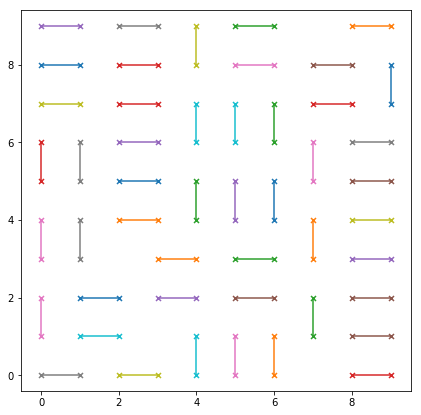

In [5]:
optimize(10)

50x50 lattice

final energy = -1156


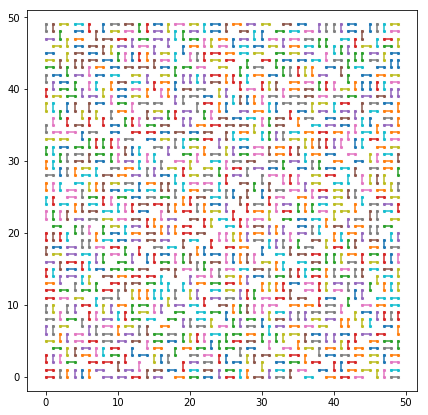

In [6]:
optimize(50)